<a href="https://colab.research.google.com/github/Nayal17/Time_Series_Analysis_And_Forecasting-/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install --upgrade "kaleido==0.1.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import plotly.express as px

In [20]:
df = pd.read_csv(r'http://ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv')

In [21]:
df.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [22]:
df['Month-Year'] = pd.to_datetime(df['Month-Year'],format="%b-%y") # %b for short form of months and %y for last two digits of year

In [23]:
# df['Month'] = df['Month-Year'].dt.month
# df['Year'] = df['Month-Year'].dt.year
df = df.rename(columns={"Month-Year":"Date","Number of Tractor Sold":"Sales"})

In [24]:
df

,Date,Sales
0,2003-01-01,141
1,2003-02-01,157
2,2003-03-01,185
3,2003-04-01,199
4,2003-05-01,203
...,...,...
139,2014-08-01,848
140,2014-09-01,640
141,2014-10-01,581
142,2014-11-01,519


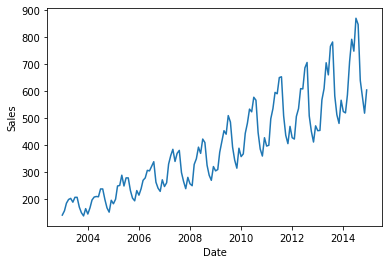

In [25]:
sns.lineplot(data=df,x="Date",y="Sales")


***Decomposition***: Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise. Hence we just use trend and seasonality for future prediction and ignores the unpredictable part.

The additive model is Y[t] = T[t] + S[t] + e[t]        (trend,seasonality and error)

The multiplicative model is Y[t] = T[t] * S[t] * e[t]

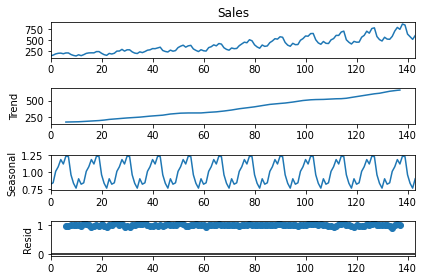

In [26]:
decompose = seasonal_decompose(df['Sales'],model='multipicable',period=12) # model: additive or multiplicable
# decompose.seasonal.plot() # we have 144 months(2003-2015) in x axis and multiplicative factor in y axis
# decompose.trend.plot() # we have 144 months(2003-2015) in x axis and sales in y axis
# decompose.resid.plot() # residual/error/remainder
decompose.plot() 
plt.show()

For future the trend is forecasted and we will multiply that forecasted trend with seasonality. Hence seasonality is not forecasted, only the trend is.



The ***NAIVE*** decomposition not always able to extract the seasonality or the residual. Hence there is another way of decomposition known as ***STL*** or ***LOESS*** decomposition.

The key inputs into STL are:

>**season** - The length of the seasonal smoother. Must be odd.

>**trend** - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.

>**low_pass** - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

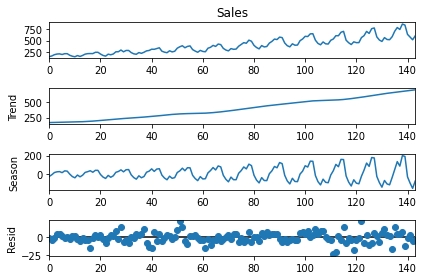

In [27]:
stl = STL(df.Sales,period=12).fit() # stl decomposes in additive way , we we want multiplicative way then we need to apply log
stl.plot()
plt.show()

Multiplicative way with STL

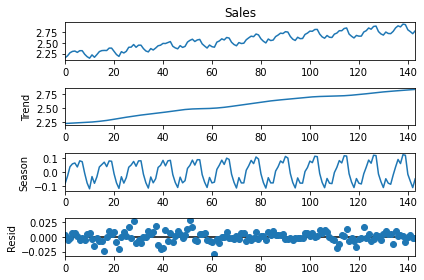

In [28]:
stl = STL(np.log10(df.Sales),period=12).fit() 
stl.plot()
plt.show()

# Lag_plots to see autocorrelation in single variable wit a particular lag in time series

The linear relationship shows that data is not random and an autoregressive model can be used.
1st plot shows the relationship month wise.
2nd plot shows the relationship one half of year with other.
3rd plot shows the relationship year wise, which is highly correlated.



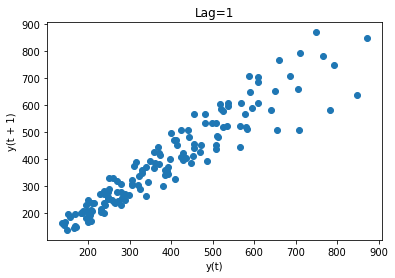

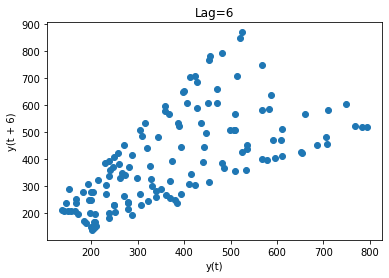

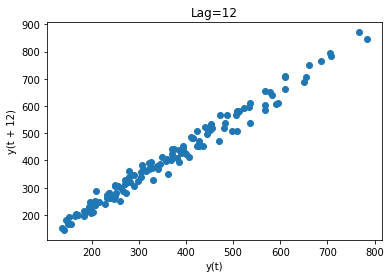

In [29]:
pd.plotting.lag_plot(df.Sales,lag=1);plt.title("Lag=1")
plt.show()
pd.plotting.lag_plot(df.Sales,lag=6);plt.title("Lag=6")
plt.show()
pd.plotting.lag_plot(df.Sales,lag=12);plt.title("Lag=12")
plt.show()

***pandas autocorrelation plot***

As we have monthly sales so lag=24 represent a lag of 24 months, that's why the graph hits local maxima after almost 12 months, which shows high correlation with year wise sales. 

The horizontal gray line shows the 90% confidence interval and the dotted line shows 95% confidence interval.

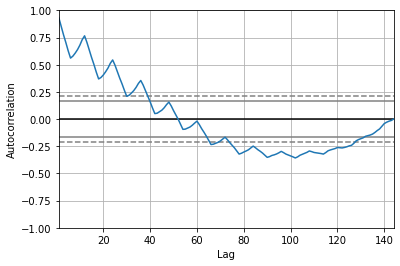

In [30]:
pd.plotting.autocorrelation_plot(df.Sales)

#Moving average

It is the mean of the last n values.

In [31]:
ma_sales = df.copy()
ma_sales["ma_3"] = df.Sales.rolling(window=3).mean()
ma_sales["ma_3_shift_1"] = df.Sales.rolling(window=3).mean().shift(1) #predicting next value using first 3 values
ma_sales.head()

,Date,Sales,ma_3,ma_3_shift_1
0,2003-01-01,141,NaN,NaN
1,2003-02-01,157,NaN,NaN
2,2003-03-01,185,161.000000,NaN
3,2003-04-01,199,180.333333,161.000000
4,2003-05-01,203,195.666667,180.333333


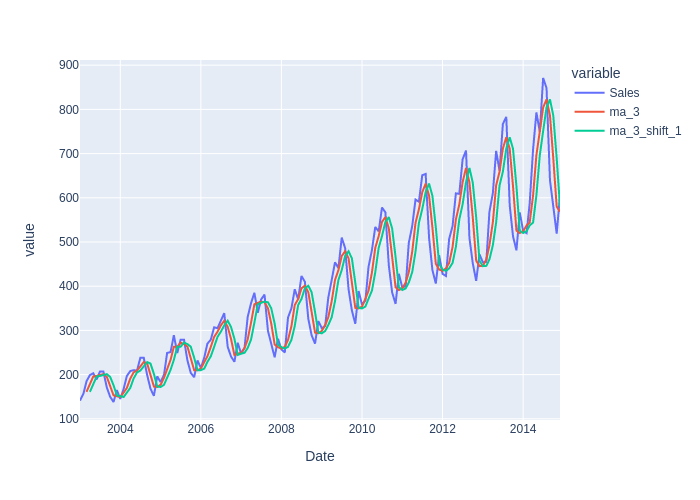

In [32]:
fig = px.line(ma_sales, x='Date', y=['Sales','ma_3','ma_3_shift_1'])
fig.show("png")

***Weighted Moving Average***

It is better solution as it give more weight to the recent values.
We can see in the below plot that wma is fitting better than ma.

,Date,Sales,ma_3,ma_3_shift_1,wma
0,2003-01-01,141,NaN,NaN,NaN
1,2003-02-01,157,NaN,NaN,NaN
2,2003-03-01,185,161.000000,NaN,168.333333
3,2003-04-01,199,180.333333,161.000000,187.333333
4,2003-05-01,203,195.666667,180.333333,198.666667


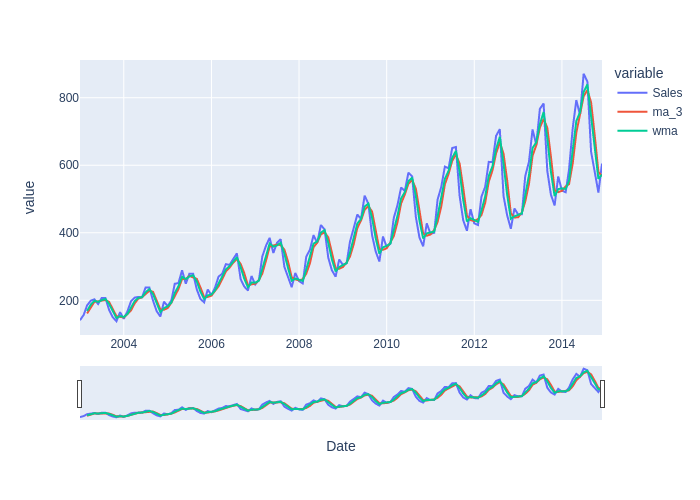

In [33]:
def wma(x,w):
  return (x*w).mean()

weights = [0.5,1.0,1.5]
ma_sales['wma'] = ma_sales.Sales.rolling(3).apply(lambda x: wma(x,weights))
display(ma_sales.head())
fig = px.line(ma_sales, x='Date', y=['Sales','ma_3','wma'])
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show("png") 

***Exponential Moving Average***

,Date,Sales,ma_3,ma_3_shift_1,wma,ewma
0,2003-01-01,141,NaN,NaN,NaN,141.0
1,2003-02-01,157,NaN,NaN,NaN,149.0
2,2003-03-01,185,161.000000,NaN,168.333333,167.0
3,2003-04-01,199,180.333333,161.000000,187.333333,183.0
4,2003-05-01,203,195.666667,180.333333,198.666667,193.0


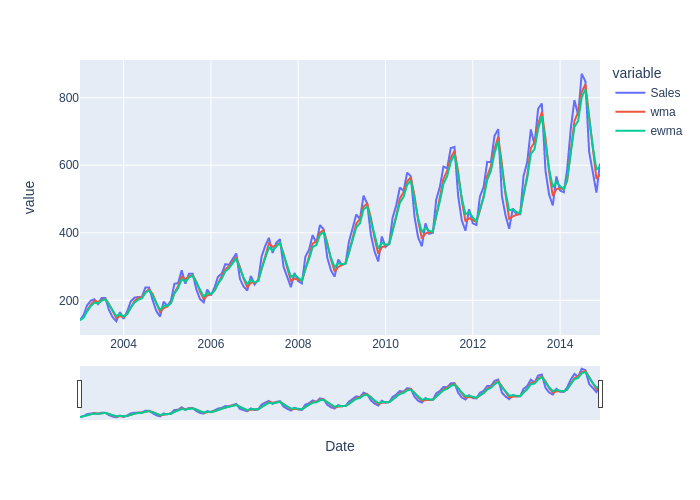

In [34]:
ma_sales['ewma'] = ma_sales.Sales.ewm(span=3, adjust=False, min_periods=1).mean() 
display(ma_sales.head())
fig = px.line(ma_sales, x='Date', y=['Sales','wma','ewma'])
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show("png") 